In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
M, N = 90, 100
imageSize = (M, N)

### Functions: 

In [3]:
def calLoss(moving, reference):
    return np.sum((moving-reference)**2)

In [4]:
def getCoorMatrix(imageShape):
    yShape, xShape = imageSize
    coorMatrix = np.asarray(np.meshgrid(np.arange(xShape), np.arange(yShape)))
    coorMatrix = np.rollaxis(coorMatrix, 0, 3)
    return coorMatrix
    

In [5]:
def getFourCorners(transformMatrix):
    # 1. calculat the coordinate matrix
    yShape, xShape = imageSize
    coorMatrix = getCoorMatrix(imageSize)
    onesMatrix = np.ones(imageSize).reshape(yShape, xShape, 1)
    coorMatrix = np.concatenate((coorMatrix, onesMatrix), axis=2)
    # 2. transformed coordinate matrix of transformed Matrix
    projectMatrix = np.dot(coorMatrix, transformMatrix.T) 
    
    # 3. set out of boundary points to zeros
    projectMatrix[projectMatrix<0] = 0
    x_matrix, y_matrix = projectMatrix[:,:,0], projectMatrix[:, :, 1]
    x_matrix[x_matrix>N-2] = 0 # maybe consider later
    y_matrix[y_matrix>M-2] = 0
    projectMatrix[:,:,0], projectMatrix[:, :, 1] = x_matrix.reshape(M,N), y_matrix.reshape(M,N)
    # 4. build nearby 4 point
    ULmatrix = np.floor(projectMatrix[:,:,0:2]).astype(int)
    DLmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]+1).reshape(M, N, 1)), axis=2).astype(int)
    URmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]+1).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]).reshape(M, N, 1)), axis=2).astype(int)
    DRmatrix = np.floor(projectMatrix[:,:,0:2]+1).astype(int)
    cornerMatrixes = [ULmatrix, URmatrix, DLmatrix, DRmatrix] # UpLeft, UpRight, DownLeft, DownRight
    return cornerMatrixes, projectMatrix

<h3>Interpolate Method</h3>
<img src="img/interpolate.png" width="20%" height="20%">
<img src="img/interpolate_method.png" width="40%" height="40%">
<img src="img/image_gradient.png" width="30%" height="30%">

In [6]:
def biInterpolate(template, transformMatrix):
    cornerMatrixes, projectMatrix = getFourCorners(transformMatrix)
    kMatrix = [] # UpLeft, UpRight, DownLeft, DownRight interpolated corner image
    for i, matrix in enumerate(cornerMatrixes):
        new = template[matrix[:,:,1],matrix[:, :, 0]]
        kMatrix.append(new)
    xr1 = projectMatrix[:,:,0] - cornerMatrixes[0][:, :, 0]
    xr2 = projectMatrix[:,:,1] - cornerMatrixes[0][:, :, 1]
    k00, k01, k10, k11 = kMatrix[2], kMatrix[0], kMatrix[3], kMatrix[1]
    newImage = (1-xr1)*((1-xr2)*k01+xr2*k00)+xr1*((1-xr2)*k11+xr2*k10)
    delta_px = (1-xr2)*(k11-k01) + xr2*(k10-k00)
    delta_py = (1-xr1)*(k00-k01) + xr1*(k10-k11)    
    return newImage, delta_px, delta_py
    

In [7]:
def calGradient(reference, moving, dTx, dTy, lr):
    coorMatrix = getCoorMatrix(imageSize)
    x_coor, y_coor = np.split(coorMatrix, [1], axis=2)
    x_coor, y_coor = x_coor.squeeze(),  y_coor.squeeze()
    dw1 = lr * np.sum((moving - reference) * dTx * x_coor)
    dw2 = lr * np.sum((moving - reference) * dTx * y_coor)
    dw3 = 100 * lr * np.sum((moving - reference) * dTx)
    
    dw4 = lr * np.sum((moving - reference) * dTy * x_coor)
    dw5 = lr * np.sum((moving - reference) * dTy * y_coor)
    dw6 = 100 * lr * np.sum((moving - reference) * dTy)
    
    dw = np.array([[dw1, dw2, dw3],
                   [dw4, dw5, dw6],
                   [0  , 0,   1]])
    return dw


### 1. create template image

Text(0, 0.5, 'y')

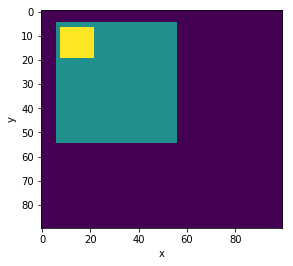

In [8]:
# initialize a zero template

template = np.zeros((M, N))
# draw a box on template
template[5:55, 6:56] = 10
template[7:20, 8:22] = 20
# template[60:100, 70:100] = 20
plt.imshow(template)
plt.xlabel("x")
plt.ylabel("y")

### 2. create reference image

In [26]:
reference = np.zeros(template.shape)
import math
angle = -5*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = np.array([[angle_cos, -angle_sin, -30.0],[angle_sin, angle_cos, 4.0],[0.0, 0.0, 1.0]])

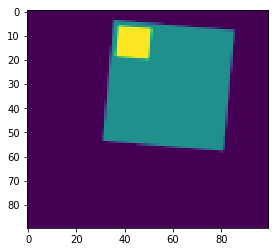

In [27]:
newImage, _, _ = biInterpolate(template, transformMatrix) # May have some edge problem
reference = newImage
plt.imshow(reference)

### 3. Gradient Descent

153868.88125517886
134311.1073713012
113715.64669957646
96068.53684335072
79491.5147453503
63950.53778489709
49402.70004149663
35897.70076972907
23933.94233641557
13419.822254693301
5670.860251835582
1595.5197611159322
391.20467899535004
99.04332278752564
24.710785878346556
5.830942543348798
1.4091564027722723
0.3360565219029519
0.07857953035652902
0.01811742071167315


/anaconda3/envs/Titanic/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.004172188981822313
0.0009607977803463608
0.00022125854663803326
5.095280622361883e-05
1.1733731529504658e-05
2.702117181431993e-06
6.222604614703932e-07
1.4329803412875097e-07
3.2999568244273223e-08
7.599347129475917e-09
1.7500252196796423e-09
4.030067632027052e-10
9.280691528043184e-11
2.137215778060656e-11
4.921714755890444e-12
1.1334032987357597e-12
2.610071855262535e-13
6.010632782081648e-14
1.3841676538325746e-14
3.187566563634591e-15
7.340623371046506e-16
1.6905230840273977e-16
3.892964718439148e-17
8.967634397889596e-18
2.0672144423837695e-18
4.778153467897215e-19
1.1184772319658553e-19
2.738388594918244e-20
7.897610594719995e-21
3.4267687618085856e-21


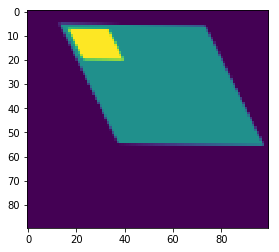

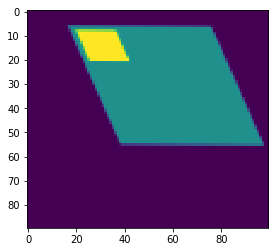

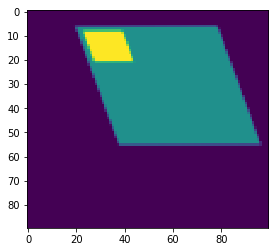

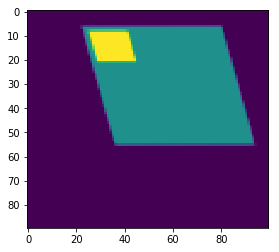

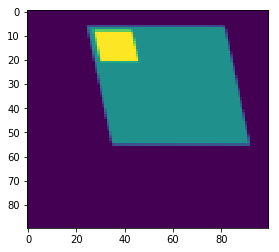

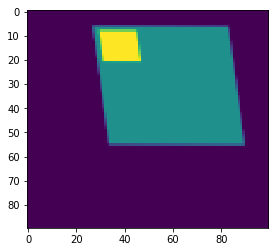

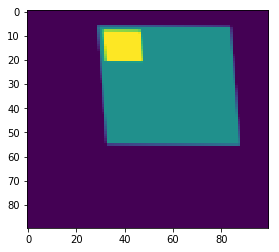

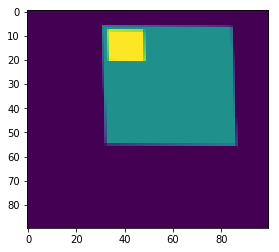

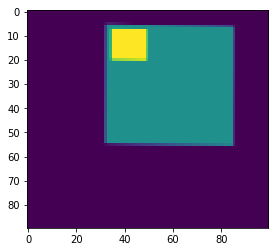

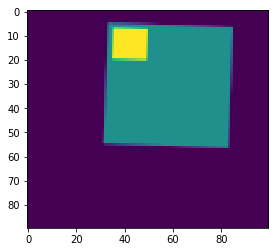

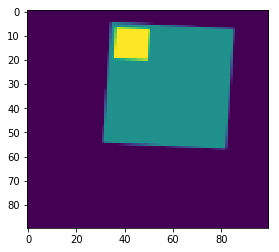

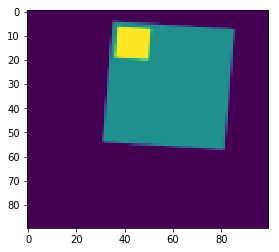

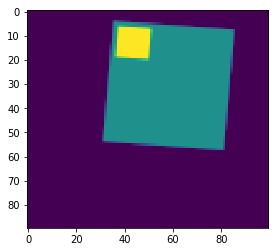

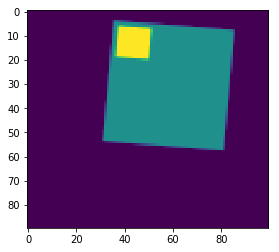

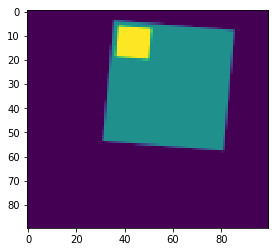

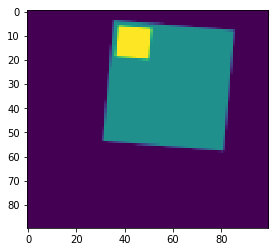

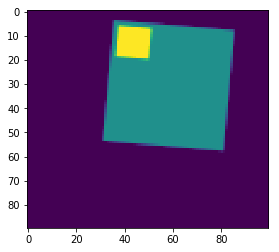

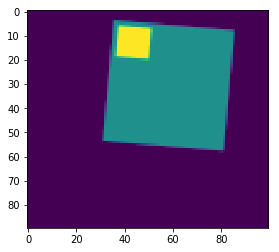

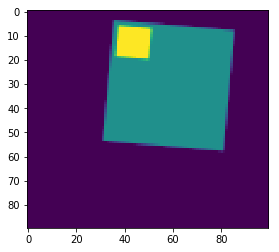

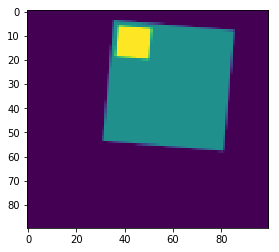

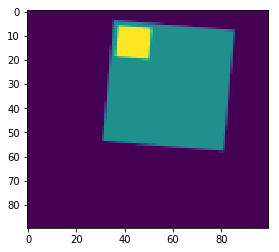

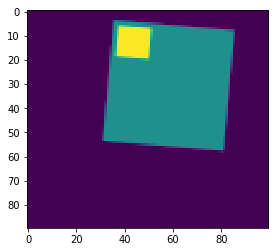

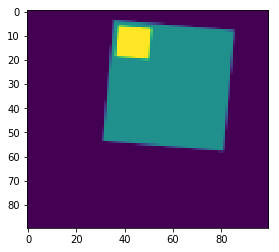

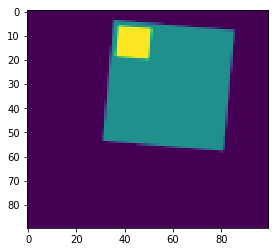

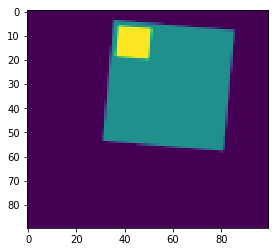

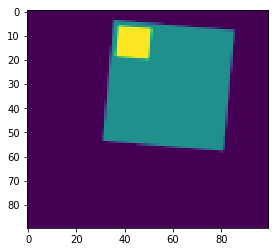

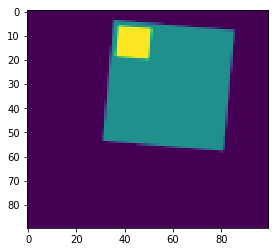

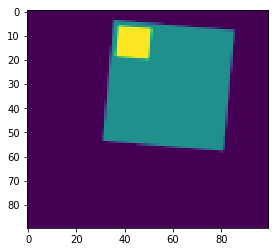

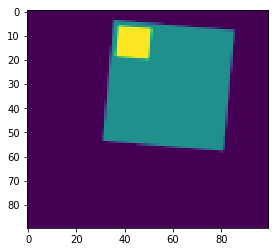

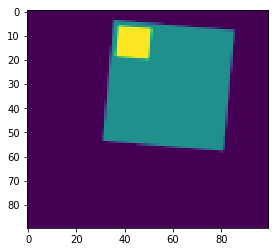

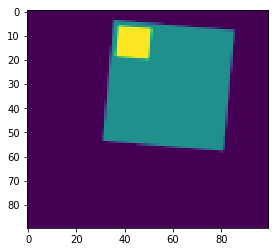

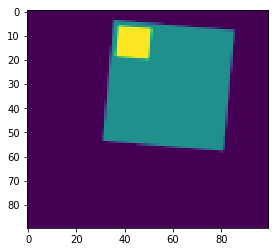

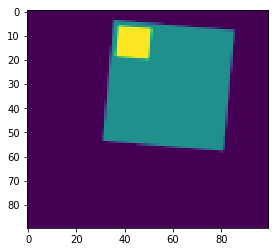

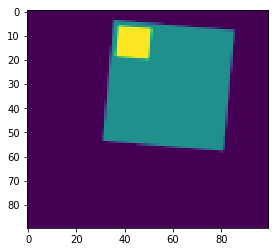

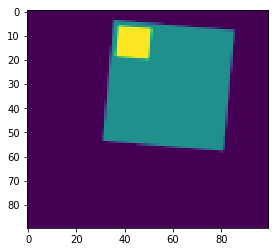

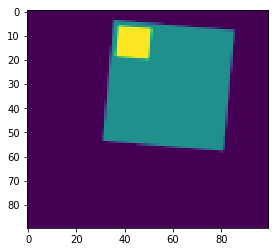

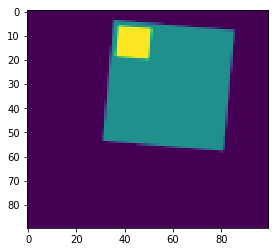

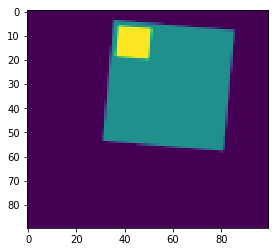

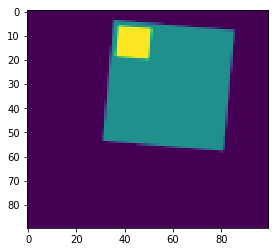

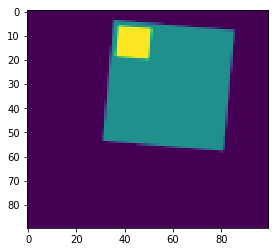

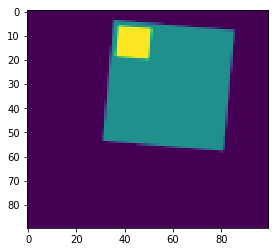

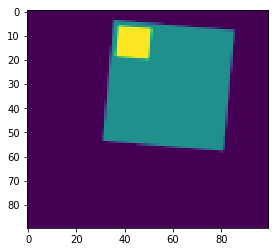

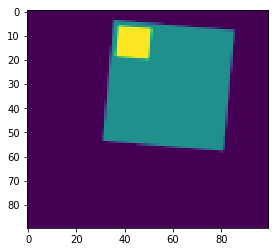

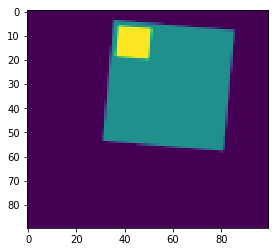

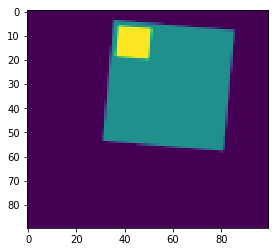

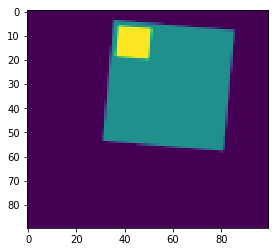

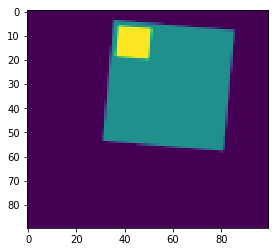

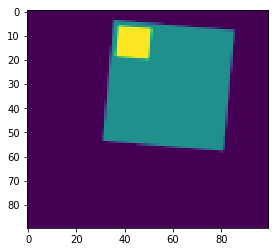

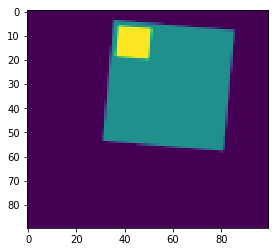

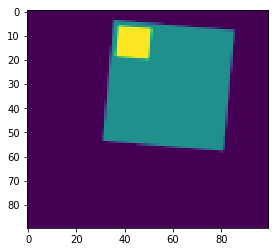

In [28]:
transMatrix = np.array([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
lr = 1e-8
i = 0
losses = []
iteration = 50000
while i < iteration:
    moving, dTx, dTy = biInterpolate(template, transMatrix)
    delta_weights = calGradient(reference, moving, dTx, dTy, lr)
    transMatrix -= delta_weights
    loss = calLoss(moving, reference)
    i += 1
    losses.append(loss)
    if i%1000 == 0:
        plt.figure(i//1000)
        plt.imshow(moving)
        print(loss)



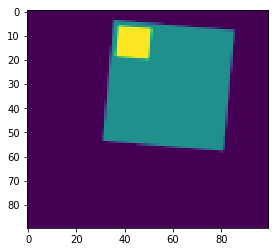

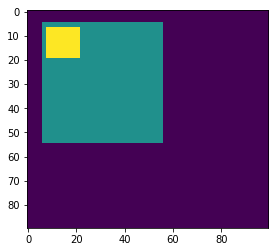

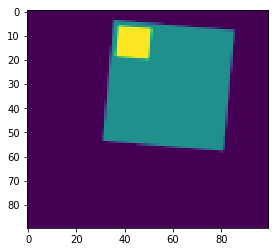

In [29]:
plt.figure(1)
plt.imshow(reference)
plt.figure(2)
plt.imshow(template)
plt.figure(3)
plt.imshow(moving)

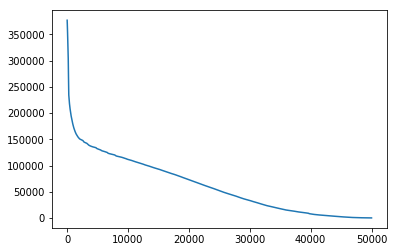

In [13]:
plt.plot(np.arange(iteration), losses)